<a href="https://colab.research.google.com/github/ImalYH/Final-Year-Project/blob/main/FinalPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, adjusted_rand_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.neural_network import MLPClassifier


**Neural Network**

In [33]:
dataSet = pd.read_csv('/content/drive/MyDrive/morereduced.csv')

dataSet.dropna(inplace=True)
X = dataSet.drop(columns=['yellowCard'])
y = dataSet['yellowCard']
#print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Only keep numeric columns
X_train = X_train.select_dtypes(include=['float64', 'int64'])
X_test = X_test.select_dtypes(include=['float64', 'int64'])


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
#Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))

#Build the model
neuralNetworkModel = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

#Compile the model
neuralNetworkModel.compile(optimizer=Adam(learning_rate=0.001),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

#Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Train the model
history = neuralNetworkModel.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

#Predict probabilities on test set
y_pred_proba = neuralNetworkModel.predict(X_test)

#Convert probabilities to labels using a lower threshold
threshold = 0.35
y_pred = (y_pred_proba > threshold).astype(int)

#Print classification report
print(f"\nClassification Report (Threshold = {threshold}):")
print(classification_report(y_test, y_pred))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2031/2031 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5622 - loss: 0.6824 - val_accuracy: 0.5837 - val_loss: 0.6694
Epoch 2/50
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5819 - loss: 0.6712 - val_accuracy: 0.5989 - val_loss: 0.6664
Epoch 3/50
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5872 - loss: 0.6670 - val_accuracy: 0.5952 - val_loss: 0.6637
Epoch 4/50
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5924 - loss: 0.6651 - val_accuracy: 0.6004 - val_loss: 0.6628
Epoch 5/50
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5970 - loss: 0.6624 - val_accuracy: 0.6010 - val_loss: 0.6609
Epoch 6/50
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5980 - loss: 0.6623 - val_accuracy: 0.6002 - val_loss: 0.6594
Epoch 7/50
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5968 - loss: 0.6622 - val_accuracy: 0.6031 - val_loss: 0.6593
Epoch 8/50
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6024 - loss: 0.6596 - val_accu

In [35]:
loss, accuracy = neuralNetworkModel.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

#Predict on test data
y_pred = (neuralNetworkModel.predict(X_test) > 0.5).astype("int32")
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Test Accuracy: 60.89%
635/635 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy Score: 0.6088755356351279


**Card Prediction in Neural Network**

In [36]:
input_data = pd.DataFrame({
    'gameID': [81],
    'playerID': [554],
    'goals': [0],
    'ownGoals': [0],
    'shots': [3],
    'xGoals': [0.263604],
    'xGoalsChain': [0.255811],
    'xGoalsBuildup': [0.10655],
    'assists': [0],
    'keyPasses': [0],
    'xAssists': [0],
    'positionOrder': [11],
    'time': [10]
})
#Preprocess
input_data_scaled = scaler.transform(input_data)

#Predict
prediction = neuralNetworkModel.predict(input_data_scaled)
print(f"Raw Model Output: {prediction[0][0]}")
predicted_outcome = (prediction > 0.5).astype("int32")
print(f"Prediction: {predicted_outcome[0][0]} (1 = likely, 0 = unlikely)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Raw Model Output: 0.13568271696567535
Prediction: 0 (1 = likely, 0 = unlikely)


In [37]:
input_data = pd.DataFrame({
    'gameID': [81],
    'playerID': [554],
    'goals': [0],
    'ownGoals': [0],
    'shots': [2],
    'xGoals': [0.253604],
    'xGoalsChain': [0.255811],
    'xGoalsBuildup': [0.20651],
    'assists': [0],
    'keyPasses': [0],
    'xAssists': [0],
    'positionOrder': [11],
    'time': [90]
})
#Preprocess
input_data_scaled = scaler.transform(input_data)

#Predict
prediction = neuralNetworkModel.predict(input_data_scaled)
print(f"Raw Model Output: {prediction[0][0]}")
predicted_outcome = (prediction > 0.5).astype("int32")
print(f"Prediction: {predicted_outcome[0][0]} (1 = likely, 0 = unlikely)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Raw Model Output: 0.5341637134552002
Prediction: 1 (1 = likely, 0 = unlikely)


ROC Curve - Neural Network

635/635 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


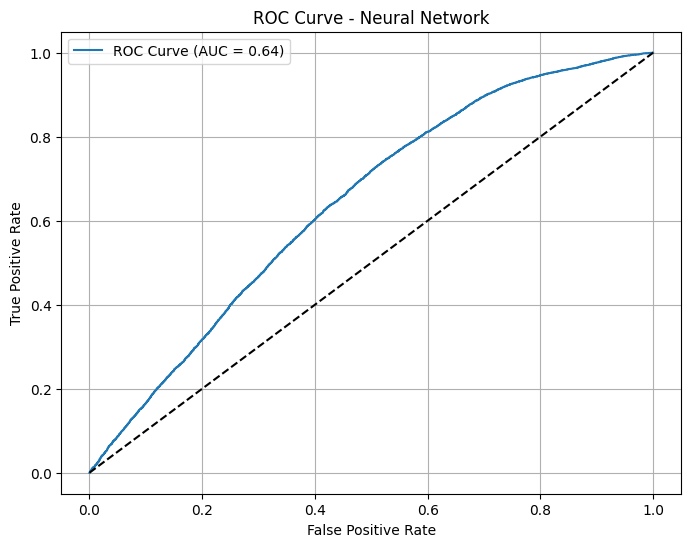

In [38]:
#ROC Curve for Neural Network
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc
import matplotlib.pyplot as plt

#Get predicted probabilities
y_probs = neuralNetworkModel.predict(X_test).flatten()

#ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend()
plt.grid()
plt.show()


Confusion Matrix - Neural Network

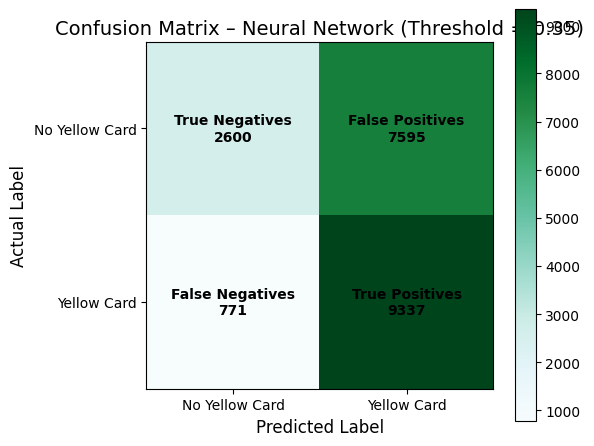

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#Apply threshold to predicted probabilities
threshold = 0.35
y_pred_nn = (y_pred_proba > threshold).astype(int)

#Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)
labels = [["True Negatives", "False Positives"], ["False Negatives", "True Positives"]]

#Plot
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='BuGn')
plt.title(f'Confusion Matrix – Neural Network (Threshold = {threshold})', fontsize=14)
plt.colorbar(im)

#Axis labels
classes = ['No Yellow Card', 'Yellow Card']
tick_marks = [0, 1]
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(classes, fontsize=10)
ax.set_yticklabels(classes, fontsize=10)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)

#Annotate each cell with value
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = f"{labels[i][j]}\n{cm[i, j]}"
        ax.text(j, i, text, ha="center", va="center", fontsize=10, fontweight="bold", color="black")

plt.tight_layout()
plt.grid(False)
plt.show()



Precision Recall Curve  - Neural Network

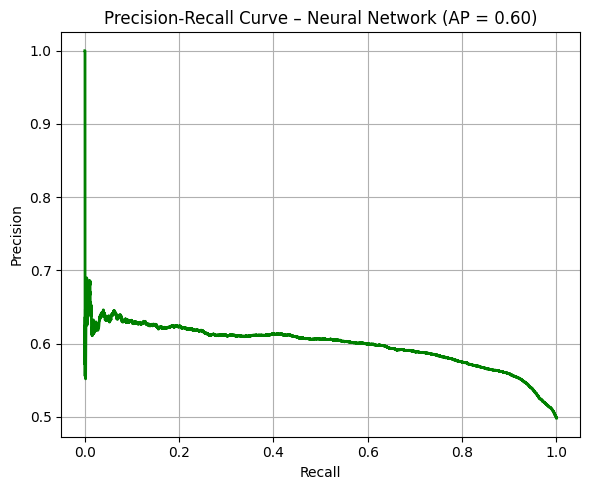

In [40]:
#Calculate precision-recall for Neural Network
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_pred_proba)
ap_nn = average_precision_score(y_test, y_pred_proba)

#Plot
plt.figure(figsize=(6, 5))
plt.plot(recall_nn, precision_nn, color='green', linewidth=2)
plt.title(f'Precision-Recall Curve – Neural Network (AP = {ap_nn:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.tight_layout()
plt.show()


Logistic Regression  - 0.5

In [41]:
#Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

#Predict probabilities for the test set
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

#Predict classes for the test set
y_pred = log_reg.predict(X_test_scaled)


In [42]:
#Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Evaluation:
Accuracy: 56.78%
ROC-AUC Score: 0.60

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.38      0.47     10195
           1       0.55      0.75      0.63     10108

    accuracy                           0.57     20303
   macro avg       0.58      0.57      0.55     20303
weighted avg       0.58      0.57      0.55     20303



SMOTE

In [43]:
#SMOTE and Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

#Preprocess data
X = dataSet.drop(columns=['yellowCard'])
y = dataSet['yellowCard']

#Encode categorical variables if any
X = pd.get_dummies(X, drop_first=True)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Apply SMOTE to balance the training set
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

#Train logistic regression
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

#Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6046889622223317
ROC-AUC Score: 0.6401767448470121
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.51      0.56     10217
           1       0.58      0.70      0.64     10086

    accuracy                           0.60     20303
   macro avg       0.61      0.61      0.60     20303
weighted avg       0.61      0.60      0.60     20303



Confusion Matrix - Logistic Regression 0.5

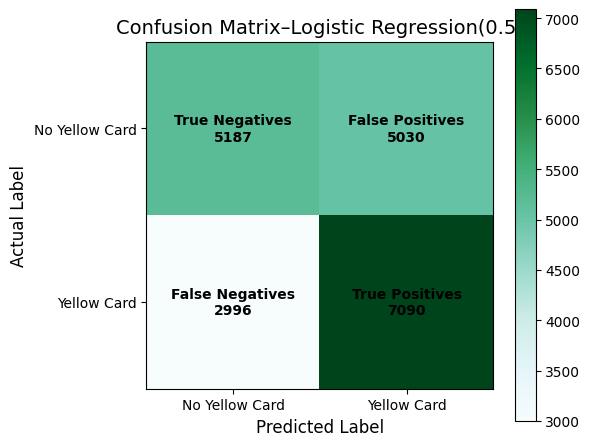

In [44]:
#Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = [["True Negatives", "False Positives"], ["False Negatives", "True Positives"]]

#Plot
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='BuGn')  # Light green/blue tone
plt.title('Confusion Matrix–Logistic Regression(0.5)', fontsize=14)
plt.colorbar(im)

#Axis labels
classes = ['No Yellow Card', 'Yellow Card']
tick_marks = [0, 1]
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(classes, fontsize=10)
ax.set_yticklabels(classes, fontsize=10)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)

#Annotate each cell with value + meaning
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = f"{labels[i][j]}\n{cm[i, j]}"
        ax.text(j, i, text, ha="center", va="center", fontsize=10, fontweight="bold", color="black")

plt.tight_layout()
plt.grid(False)
plt.show()


ROC Curve - Logistic Regression 0.5

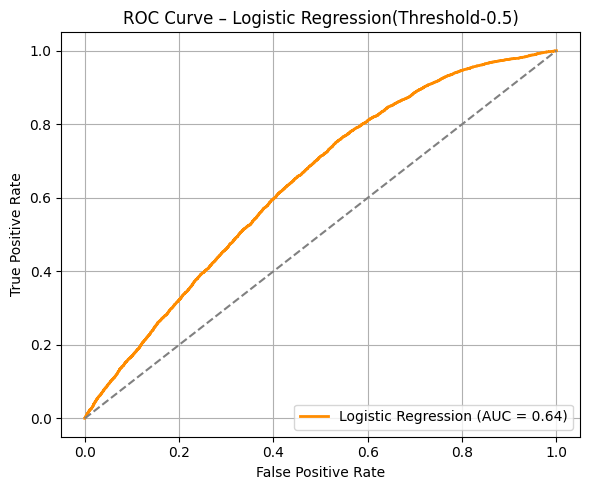

In [45]:
#ROC Curve for Logistic Regression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#Predict probabilities for the positive class
y_proba_logreg = model.predict_proba(X_test_scaled)[:, 1]

#Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_logreg)
roc_auc = auc(fpr, tpr)

#Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression(Threshold-0.5)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Precision Recall Curve  - Logistic Regression 0.5

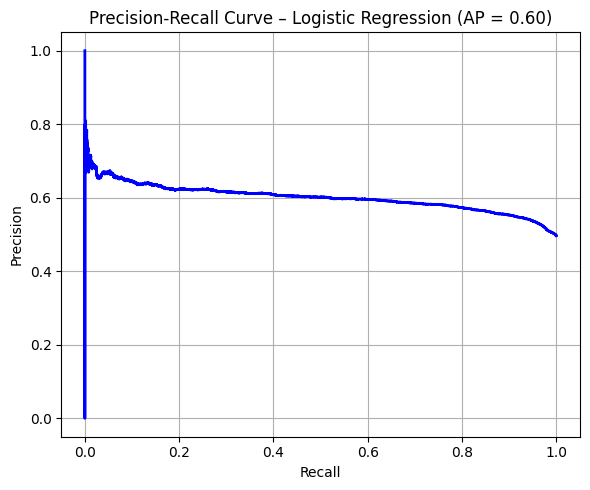

In [46]:
#calculate Precision - Recall value for Logistic Regression
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

#Calculate precision-recall for Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_logreg)
ap_lr = average_precision_score(y_test, y_proba_logreg)

#Plot
plt.figure(figsize=(6, 5))
plt.plot(recall_lr, precision_lr, color='blue', linewidth=2)
plt.title(f'Precision-Recall Curve – Logistic Regression (AP = {ap_lr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.tight_layout()
plt.show()


Logistic Regression 0.35

In [47]:
X = dataSet.drop(columns=['yellowCard'])
y = dataSet['yellowCard']
X = pd.get_dummies(X, drop_first=True)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

#Train Logistic Regression
start_time = time.time()
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

#Predict
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
threshold = 0.35
y_pred_custom = (y_prob >= threshold).astype(int)

#Evaluate
accuracy = accuracy_score(y_test, y_pred_custom)
roc_auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred_custom)

#Output
print(f"Custom Threshold: {threshold}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:")
print(report)


Custom Threshold: 0.35
Accuracy: 0.5888
ROC AUC: 0.6402
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.28      0.41     10217
           1       0.55      0.90      0.69     10086

    accuracy                           0.59     20303
   macro avg       0.65      0.59      0.55     20303
weighted avg       0.65      0.59      0.54     20303



Confusion Matrix - Logistic Regression 0.35

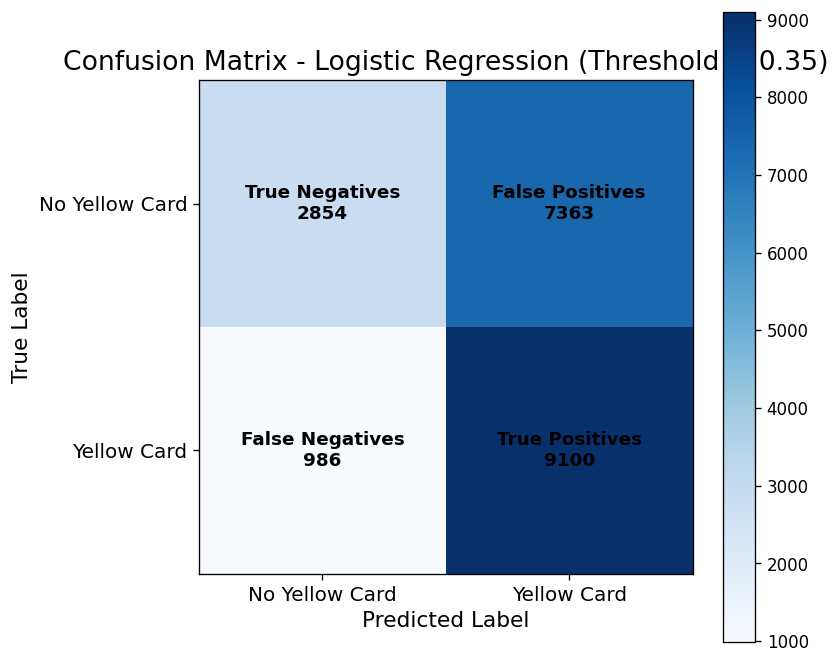

In [48]:
#Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
labels = [["True Negatives", "False Positives"], ["False Negatives", "True Positives"]]

#Plot
fig, ax = plt.subplots(figsize=(7, 6), dpi=120)  # High DPI for better clarity
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (Threshold = 0.35)', fontsize=16)
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=10)

#Axis labels
classes = ['No Yellow Card', 'Yellow Card']
tick_marks = [0, 1]
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(classes, fontsize=12)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)

#Annotate each cell with value and meaning
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cell_text = f"{labels[i][j]}\n{cm[i, j]}"
        ax.text(j, i, cell_text, ha="center", va="center", fontsize=11, fontweight="bold", color="black")

plt.tight_layout()
plt.grid(False)
plt.show()

ROC Curve - Logistic Regression 0.35

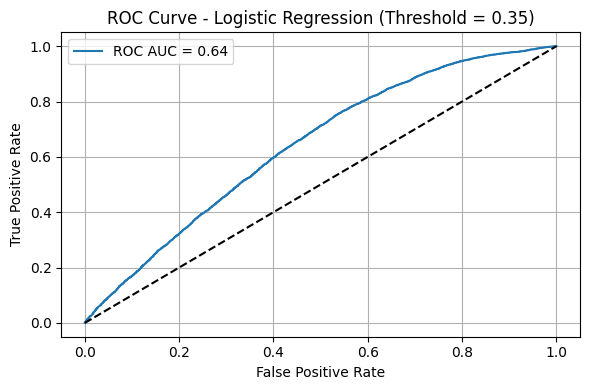

In [49]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_val:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Threshold = 0.35)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Precision Recall Curve - Logistic Regression 0.5

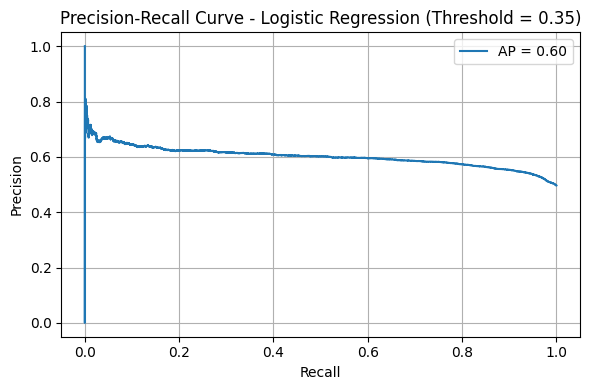

In [50]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression (Threshold = 0.35)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Performance Comparison

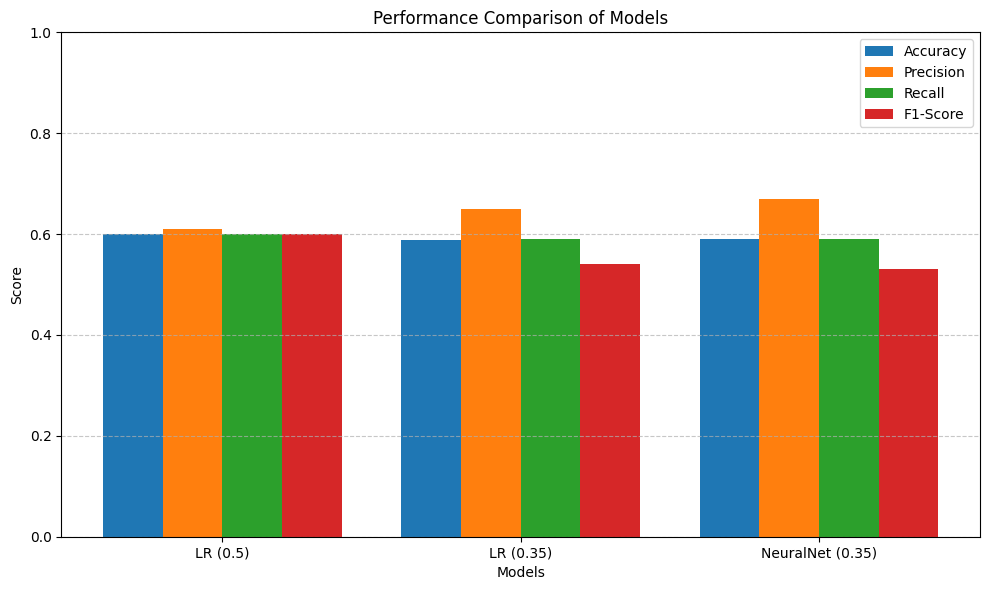

In [51]:
#Performance metrics
models = ['LR (0.5)', 'LR (0.35)', 'NeuralNet (0.35)']

# Weighted average metrics from classification reports
accuracy = [0.60, 0.5888, 0.59]
precision = [0.61, 0.65, 0.67]
recall = [0.60, 0.59, 0.59]
f1_score = [0.60, 0.54, 0.53]

#Positioning for bars
x = np.arange(len(models))
width = 0.2  # Width of each bar

#Plotting
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 1.5 * width, accuracy, width, label='Accuracy')
ax.bar(x - 0.5 * width, precision, width, label='Precision')
ax.bar(x + 0.5 * width, recall, width, label='Recall')
ax.bar(x + 1.5 * width, f1_score, width, label='F1-Score')

#Labels and formatting
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Performance Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Computational Time Comparison

LR (0.5) Training Time: 0.1869 seconds
LR (0.35) Training Time: 0.1839 seconds
NeuralNet (0.35) Training Time: 38.3592 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


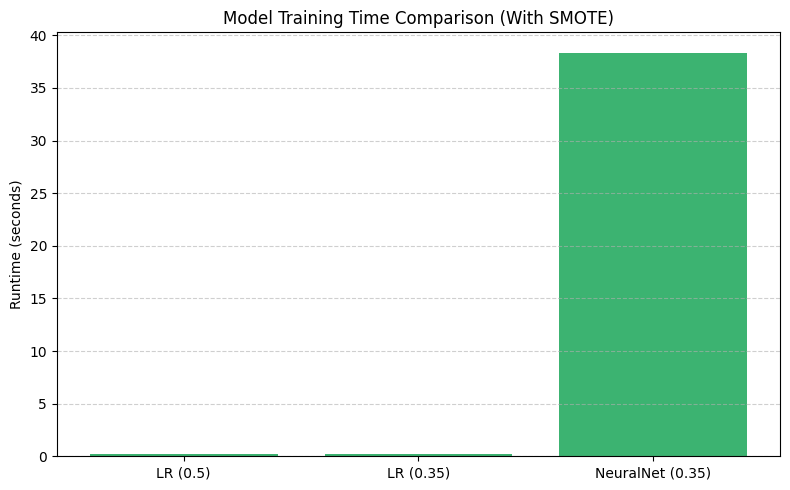

In [52]:
X = dataSet.drop(columns=['yellowCard'])
y = dataSet['yellowCard']
X = pd.get_dummies(X, drop_first=True)

#Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

#Store runtimes
model_names = ['LR (0.5)', 'LR (0.35)', 'NeuralNet (0.35)']
runtimes = []

#Logistic Regression (Threshold 0.5) with SMOTE
start_time = time.time()
log_reg_05 = LogisticRegression(random_state=42)
log_reg_05.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
runtimes.append(end_time - start_time)

#Logistic Regression (Threshold 0.35) with SMOTE
start_time = time.time()
log_reg_035 = LogisticRegression(random_state=42)
log_reg_035.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
runtimes.append(end_time - start_time)

#Neural Network (Threshold 0.35)
start_time = time.time()
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42)
nn_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
runtimes.append(end_time - start_time)

#Print runtimes
for name, rt in zip(model_names, runtimes):
    print(f"{name} Training Time: {rt:.4f} seconds")

#Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, runtimes, color='mediumseagreen')
plt.ylabel('Runtime (seconds)')
plt.title('Model Training Time Comparison (With SMOTE)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()